In [ ]:
!pip install ujson

In [4]:
import os
import torch
from PIL import Image
import pandas as pd 
import sys 
import json 
import importlib
from pathlib import Path 
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt

In [5]:
sys.path.append('../')
from src import dataset_lvis
from src import metrics
from src import helper_functions as helper

In [6]:
importlib.reload(dataset_lvis)
importlib.reload(helper)

<module 'src.helper_functions' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/../src/helper_functions.py'>

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
data_args = {'stage': 'val',
            'classes': ['airplane','sofa'], #, 'signboard'],
            'ds_path' : "/home/Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640 }
val_data = dataset_lvis.LVISData(**data_args)

Loaded 180 images!
245 annotations found!
classes : {1: 'airplane', 2: 'sofa'}
stage:  val
ds_path:  /home/Datasets/coco/
labels_f:  /home/Datasets/coco/annotations/lvis_v1_val.json
imgs_dir:  /home/Datasets/coco/images/val2017


In [9]:
#Split dataset to test and train
indices = torch.randperm(len(val_data)).tolist()


#dataset_train = torch.utils.data.Subset(val_data, indices[:150])
dataset_test = torch.utils.data.Subset(val_data, indices[150:])


#train_loader = torch.utils.data.DataLoader(
# dataset_train, batch_size=5, shuffle=True, #num_workers=4,
# collate_fn=CollateCustom())


test_loader = torch.utils.data.DataLoader(
 dataset_test, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())


In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [11]:
num_classes = 3

#model setup 
model = get_instance_segmentation_model(num_classes)
model.to(device)

helper.load_model(model, 'model.pth')


Loaded from model model.pth!


In [12]:
model.eval() 
None

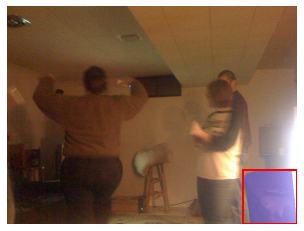

In [13]:
idx, X, y= next(iter(test_loader))
val_data.plot_img_with_ann(idx[0], bboxes = True)

In [14]:
print(y[0])

{'boxes': tensor([[519.6600, 360.2900, 639.6600, 480.2900]]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]], dtype=torch.uint8), 'labels': tensor([2])}


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


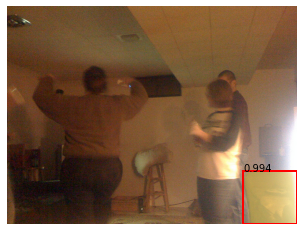

In [15]:
y_pred = model(X.to(device))
val_data.plot_predictions(idx[0], y_pred)

In [20]:
temp_preds= {} 
temp_gt = {} 

for i in range(2):
    idx, X, y= next(iter(test_loader))
    print(idx[0])
    y_pred = model(X.to(device))
    #print(y_pred)
    temp_preds[idx[0]] = y_pred[0]
    temp_gt[idx[0]] = y[0]


print("Ground Truths:")
print(temp_gt) 
print("Predicitions:")
print(temp_preds)

90
87
Ground Truths:
{90: {'boxes': tensor([[107.3250, 179.8125, 320.3250, 217.8125],
        [  0.0000,  49.2450, 320.0000, 448.2450]]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'labels': tensor([1, 1])}, 87: {'boxes': tensor([[142.0200, 183.0200, 368.0200, 250.0200]]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'labels': tensor([1])}}
Prediciti

In [210]:
importlib.reload(helper)

<module 'src.helper_functions' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/../src/helper_functions.py'>

In [211]:
importlib.reload(metrics)

<module 'src.metrics' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/../src/metrics.py'>

In [212]:
#gts, preds = helper.filter_predictions_to_class(temp_preds, temp_gt, 1) 
#print(gts) 
#print(preds)

In [235]:
gts, preds = helper.filter_predictions_to_class(temp_preds, temp_gt, 2) 
print(gts) 
print(preds)

#for i in preds:
#    print(i)

[[83, [[36.689998626708984, 329.19000244140625, 639.6900024414062, 480.19000244140625]]]]
[[83, [0.9455786347389221, 0.08073345571756363, 0.07380245625972748], [[54.24491500854492, 325.5041198730469, 573.3089599609375, 480.0000305175781], [599.3475952148438, 429.9798278808594, 640.0, 480.0000305175781], [38.73649597167969, 331.500244140625, 317.6068420410156, 480.0000305175781]]]]


In [236]:
def calculate_ap(predictions, ground_truth, iou_threshold, logger = True):
    
    eps = 1e-6
    
    #adding this
    total_num_predictions = 0 
    for i in range(len(predictions)):
        total_num_predictions += len(predictions[i][2])
    print("total_num_predictions:", total_num_predictions)
    
    #get number of grouth truths in each image 
    num_gt_boxes = {} 
    for i in range(len(ground_truth)):
        img_idx = ground_truth[i][0]
        num_gt_boxes[img_idx] = len(ground_truth[i][1])
    
    if logger: print("Ground Truths per image:", num_gt_boxes)
    
    #update key to store tensor with number of gt per image 
    for img_idx, val in num_gt_boxes.items():
        num_gt_boxes[img_idx] = torch.zeros(val) 
    
    if logger: print("Ground Truths per image:", num_gt_boxes)
    
    #sort by decreasing confidence score  
    predictions.sort(key= lambda x: x[1], reverse = True)
    if logger: print("Predictions after sorting:", predictions)
    
    #set up data structures for calculating precision + recall for each image 
    TP = torch.zeros(total_num_predictions) #torch.zeros(len(predictions))
    FP = torch.zeros(total_num_predictions) #torch.zeros(len(predictions)) 
    total_gts = len(ground_truth)
    
    if logger:
        print("TP:", TP) 
        print("FP:", FP) 
        print("total_gts:", total_gts)

    print("----------For each image-----------")

    #for each image, iterate through predictions to calculate tp/fp/fn 
    for idx_img, pred in enumerate(predictions):
        print("idx:", idx_img)
        print("image idx:", pred[0])
        print("pred:", pred[2])
        
        #get ground truths for same image 
        for gt in ground_truth:
            #if img idx found 
            if gt[0] == pred[0]:
                bboxes_gt = gt[1]
        print("Ground truth boxes:", bboxes_gt)
        
        total_gts_img = len(bboxes_gt)
        best_iou =0 
        best_gt_idx = -1 
        
        #calculate IOU b/w each GT box and predictions and save the best iou 
        for idx, gt in enumerate(bboxes_gt):
            best_iou =0 
            best_gt_idx = -1 
            #calculate ious b/w all prediction and IOU 
            iou = metrics.get_iou(pred[2], gt)#.tolist()
            
            iou_max = torch.max(iou).item()
            iou_max_idx = torch.argmax(iou).item()
            
            print("IOU:", iou) 
            print("max_iou_index:", iou_max_idx)
            print("max_iou:", iou_max)

            
            if iou_max>best_iou:
                best_iou = iou_max 
                best_gt_idx = idx
            
                print("best_iou:", best_iou) 
                print("best_gt_idx:", best_gt_idx)
                
        #
            if best_iou > iou_threshold:
                #detect each ground truth at most once, check not already predicted 
                if num_gt_boxes[pred[0]][best_gt_idx] == 0:
                    TP[idx] = 1
                    num_gt_boxes[pred[0]][best_gt_idx] = 1
                else:
                    FP[idx] = 1
            #if already detected or iou < threshold --> FP 
            else:
                FP[idx] = 1 

            print("num_gt_boxes:", num_gt_boxes)

        print("TP:",  TP)
        print("FP:",  FP) 
            
                
        print("-------------")
    
    
    TP_cumsum = torch.cumsum(TP, dim=0)
    FP_cumsum = torch.cumsum(FP, dim=0)
    print("TP_cumsum:", TP_cumsum)
    print("FP_cumsum:", FP_cumsum)
    
    recalls = TP_cumsum / (total_gts + eps)
    precisions = TP_cumsum / (TP_cumsum + FP_cumsum + eps)
    print("recalls:", recalls)
    print("precisions:", precisions) 
    
    #start curve at P(y)-R(x_axis) curve at 0,1
    precisions = torch.cat((torch.tensor([1]), precisions))
    recalls = torch.cat((torch.tensor([0]), recalls))
    
    ap = torch.trapz(precisions, recalls)
    print(f"AP@{iou_threshold}: {ap}")
    
    return ap
    
            

In [237]:
calculate_ap(preds, gts, 0.5)

total_num_predictions: 3
Ground Truths per image: {83: 1}
Ground Truths per image: {83: tensor([0.])}
Predictions after sorting: [[83, [0.9455786347389221, 0.08073345571756363, 0.07380245625972748], [[54.24491500854492, 325.5041198730469, 573.3089599609375, 480.0000305175781], [599.3475952148438, 429.9798278808594, 640.0, 480.0000305175781], [38.73649597167969, 331.500244140625, 317.6068420410156, 480.0000305175781]]]]
TP: tensor([0., 0., 0.])
FP: tensor([0., 0., 0.])
total_gts: 1
----------For each image-----------
idx: 0
image idx: 83
pred: [[54.24491500854492, 325.5041198730469, 573.3089599609375, 480.0000305175781], [599.3475952148438, 429.9798278808594, 640.0, 480.0000305175781], [38.73649597167969, 331.500244140625, 317.6068420410156, 480.0000305175781]]
Ground truth boxes: [[36.689998626708984, 329.19000244140625, 639.6900024414062, 480.19000244140625]]
IOU: tensor([[0.8420],
        [0.0222],
        [0.4548]])
max_iou_index: 0
max_iou: 0.8420271277427673
best_iou: 0.8420271277

tensor(1.0000)

In [238]:
calculate_ap(preds, gts, 0.5)

total_num_predictions: 3
Ground Truths per image: {83: 1}
Ground Truths per image: {83: tensor([0.])}
Predictions after sorting: [[83, [0.9455786347389221, 0.08073345571756363, 0.07380245625972748], [[54.24491500854492, 325.5041198730469, 573.3089599609375, 480.0000305175781], [599.3475952148438, 429.9798278808594, 640.0, 480.0000305175781], [38.73649597167969, 331.500244140625, 317.6068420410156, 480.0000305175781]]]]
TP: tensor([0., 0., 0.])
FP: tensor([0., 0., 0.])
total_gts: 1
----------For each image-----------
idx: 0
image idx: 83
pred: [[54.24491500854492, 325.5041198730469, 573.3089599609375, 480.0000305175781], [599.3475952148438, 429.9798278808594, 640.0, 480.0000305175781], [38.73649597167969, 331.500244140625, 317.6068420410156, 480.0000305175781]]
Ground truth boxes: [[36.689998626708984, 329.19000244140625, 639.6900024414062, 480.19000244140625]]
IOU: tensor([[0.8420],
        [0.0222],
        [0.4548]])
max_iou_index: 0
max_iou: 0.8420271277427673
best_iou: 0.8420271277

tensor(1.0000)

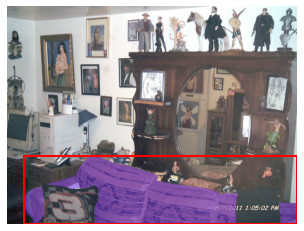

In [239]:
val_data.plot_img_with_ann(idx[0], bboxes = True)

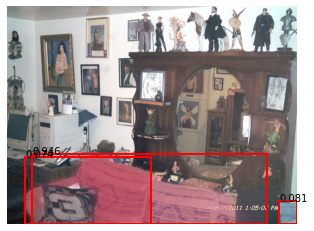

In [240]:
val_data.plot_predictions(idx[0], y_pred)

In [15]:
gts = y[0]['boxes']#[0]
preds = y_pred[0]['boxes'].to('cpu').detach()#[0]"

for i in range(len(gts)):
    gt = gts[i]   
    IOU = metrics.get_iou(preds, gt)
    print(IOU)

tensor([[0.9293]])


In [25]:
temp_preds= {} 
temp_gt = {} 


In [35]:
y[0]

{'boxes': tensor([[  0.,   0., 640., 480.]]),
 'masks': tensor([[[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1]]], dtype=torch.uint8),
 'labels': tensor([2])}

In [33]:
temp_preds[idx[0]] = y_pred[0]
temp_gt[idx[0]] = y[0]


In [34]:
gts, preds = helper.filter_to_label(temp_preds, temp_gt, 1) 
print(gts) 
print(preds)

[[50, [tensor([176.1300, 232.2100, 378.1300, 411.2100])]], [132, []]]
[[50, tensor([0.9957]), tensor([[177.4133, 239.6360, 382.0968, 410.4569]])], [132, tensor([0.9908, 0.2866, 0.0678]), tensor([[  0.0000,   5.7874, 638.3394, 465.6155],
        [316.2102,  16.2373, 640.0000, 457.9152],
        [ 88.6889, 116.1884, 595.6588, 381.5295]])]]
